<a href="https://colab.research.google.com/github/Prajaktahz/ML-Practice-Uni/blob/main/Week_6_Case_Study_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.nlab.org.uk/wp-content/uploads/nlabmain.png" style="width:40%; clear:both; margin-bottom:-20px" align=left>
<br style="clear:both;"/>

## Analytics Specializations & Applications - Week 7

# Twitter influencers
----------
Dr Georgiana Nica-Avram - University of Nottingham
[mail](mailto:georgiana.nica-avram1@nottingham.ac.uk)
[web](http://www.neodemographics.org)


## Scenario:
In this session we are considering what factors will make a twitter user a good 'influencer' for a business. There are numerous ways of considering this - "centrality", "the number of times they tweet", "how active they've been recently", and so on. However, there is no single true answer to this question - at least not one that can be arrived at without a real world A/B test (i.e. looking at how each individual might disseminate information about our business). As such, initially as a business we have to take a best guess, and use some heuristics to decide which individuals we should engage with the most as our 'influencers'.

Luckily, when it comes to Twitter, some data has been made available as part of a Kaggle Competition called ["Influencers in Social Networks"](https://www.kaggle.com/c/predict-who-is-more-influential-in-a-social-network/data). The data they provided, and which we will use, consists of some key network statistics from Twitter (e.g. followers, following, no. of retweets, etc.) corresponding to a large set of users.

In the data, these users are iteratively paired off against each other and a label attached indicating which is the better 'influencer' of the two. This lable is provided by human judgement and corresponds to our target class (i.e. our ground truth). By analysing the model to predict this ground truth, we can understand what makes a good influencer on Twitter.

### Task Loading in the Twitter summary data for each pairing
First, let's load in the data and look at the features we have available to us.

<span style="font-weight:bold; color:green;">&rarr; load the data into pandas:<span/>

In [1]:
#-- First of all, let's download the data
!wget -O train.csv "https://drive.google.com/uc?export=download&id=1mwYKT93fyGVmXrXreV-AMzM1XQ38UzPO"


--2024-03-07 14:13:54--  https://drive.google.com/uc?export=download&id=1mwYKT93fyGVmXrXreV-AMzM1XQ38UzPO
Resolving drive.google.com (drive.google.com)... 142.250.101.139, 142.250.101.113, 142.250.101.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.101.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1mwYKT93fyGVmXrXreV-AMzM1XQ38UzPO&export=download [following]
--2024-03-07 14:13:54--  https://drive.usercontent.google.com/download?id=1mwYKT93fyGVmXrXreV-AMzM1XQ38UzPO&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1259820 (1.2M) [application/octet-stream]
Saving to: ‘train.csv’

train.csv           100%[===================>]   1.20M  7.16MB/s   

In [2]:
#-- Load in training data
import pandas
data = pandas.read_csv("train.csv")
data.head()

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,...,29808,1689,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939
1,0,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,...,848,1610,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337
2,0,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,...,482,206,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333
3,0,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,...,17637,278,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634
4,1,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,...,1711,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907


The first column contains a binary label which represents a human judgement about which one of the two individuals is more influential (either person A or person B). A label '1' means A is more influential than B. 0 means B is more influential than A. Our goal would be to train a machine learning model which, for pairs of individuals, predicts the human judgement on who is more influential with high accuracy. This model could then be used in the future with a new set of people, to determine which were the most influential (Note that labels for the dataset were collected by the company "PeerIndex" via crowdsourcing).


### Loading in the Twitter summary data for each pairing
It's actually often quite hard to read tables using .head() with so many columns in. So, while we create our test and training datasets, lets summarize what we have in the data:

<span style="font-weight:bold; color:green;">&rarr; load the data into pandas, and summarize it, along with the features:<span/>

In [3]:
#-- let's have a look at the features
X = data[data.columns[1:]]
Y = data.Choice

print("Number of Datapoints:", X.shape[0])
print("Number of Input Features:", X.shape[1])
print("Features:", list(X))
print('Number of influential and non-influential users: ', data['Choice'].value_counts())

Number of Datapoints: 5500
Number of Input Features: 22
Features: ['A_follower_count', 'A_following_count', 'A_listed_count', 'A_mentions_received', 'A_retweets_received', 'A_mentions_sent', 'A_retweets_sent', 'A_posts', 'A_network_feature_1', 'A_network_feature_2', 'A_network_feature_3', 'B_follower_count', 'B_following_count', 'B_listed_count', 'B_mentions_received', 'B_retweets_received', 'B_mentions_sent', 'B_retweets_sent', 'B_posts', 'B_network_feature_1', 'B_network_feature_2', 'B_network_feature_3']
Number of influential and non-influential users:  1    2802
0    2698
Name: Choice, dtype: int64


### Relationships among variables

To get a better understanding of how variables relate to each other, let's create a scatter matrix for the first users in each pairing (A_cols), then examine the Pearson correlations each feature has with each other

In [5]:
X.columns

Index(['A_follower_count', 'A_following_count', 'A_listed_count',
       'A_mentions_received', 'A_retweets_received', 'A_mentions_sent',
       'A_retweets_sent', 'A_posts', 'A_network_feature_1',
       'A_network_feature_2', 'A_network_feature_3', 'B_follower_count',
       'B_following_count', 'B_listed_count', 'B_mentions_received',
       'B_retweets_received', 'B_mentions_sent', 'B_retweets_sent', 'B_posts',
       'B_network_feature_1', 'B_network_feature_2', 'B_network_feature_3'],
      dtype='object')

In [7]:
Y

0       0
1       0
2       0
3       0
4       1
       ..
5495    0
5496    1
5497    0
5498    0
5499    0
Name: Choice, Length: 5500, dtype: int64

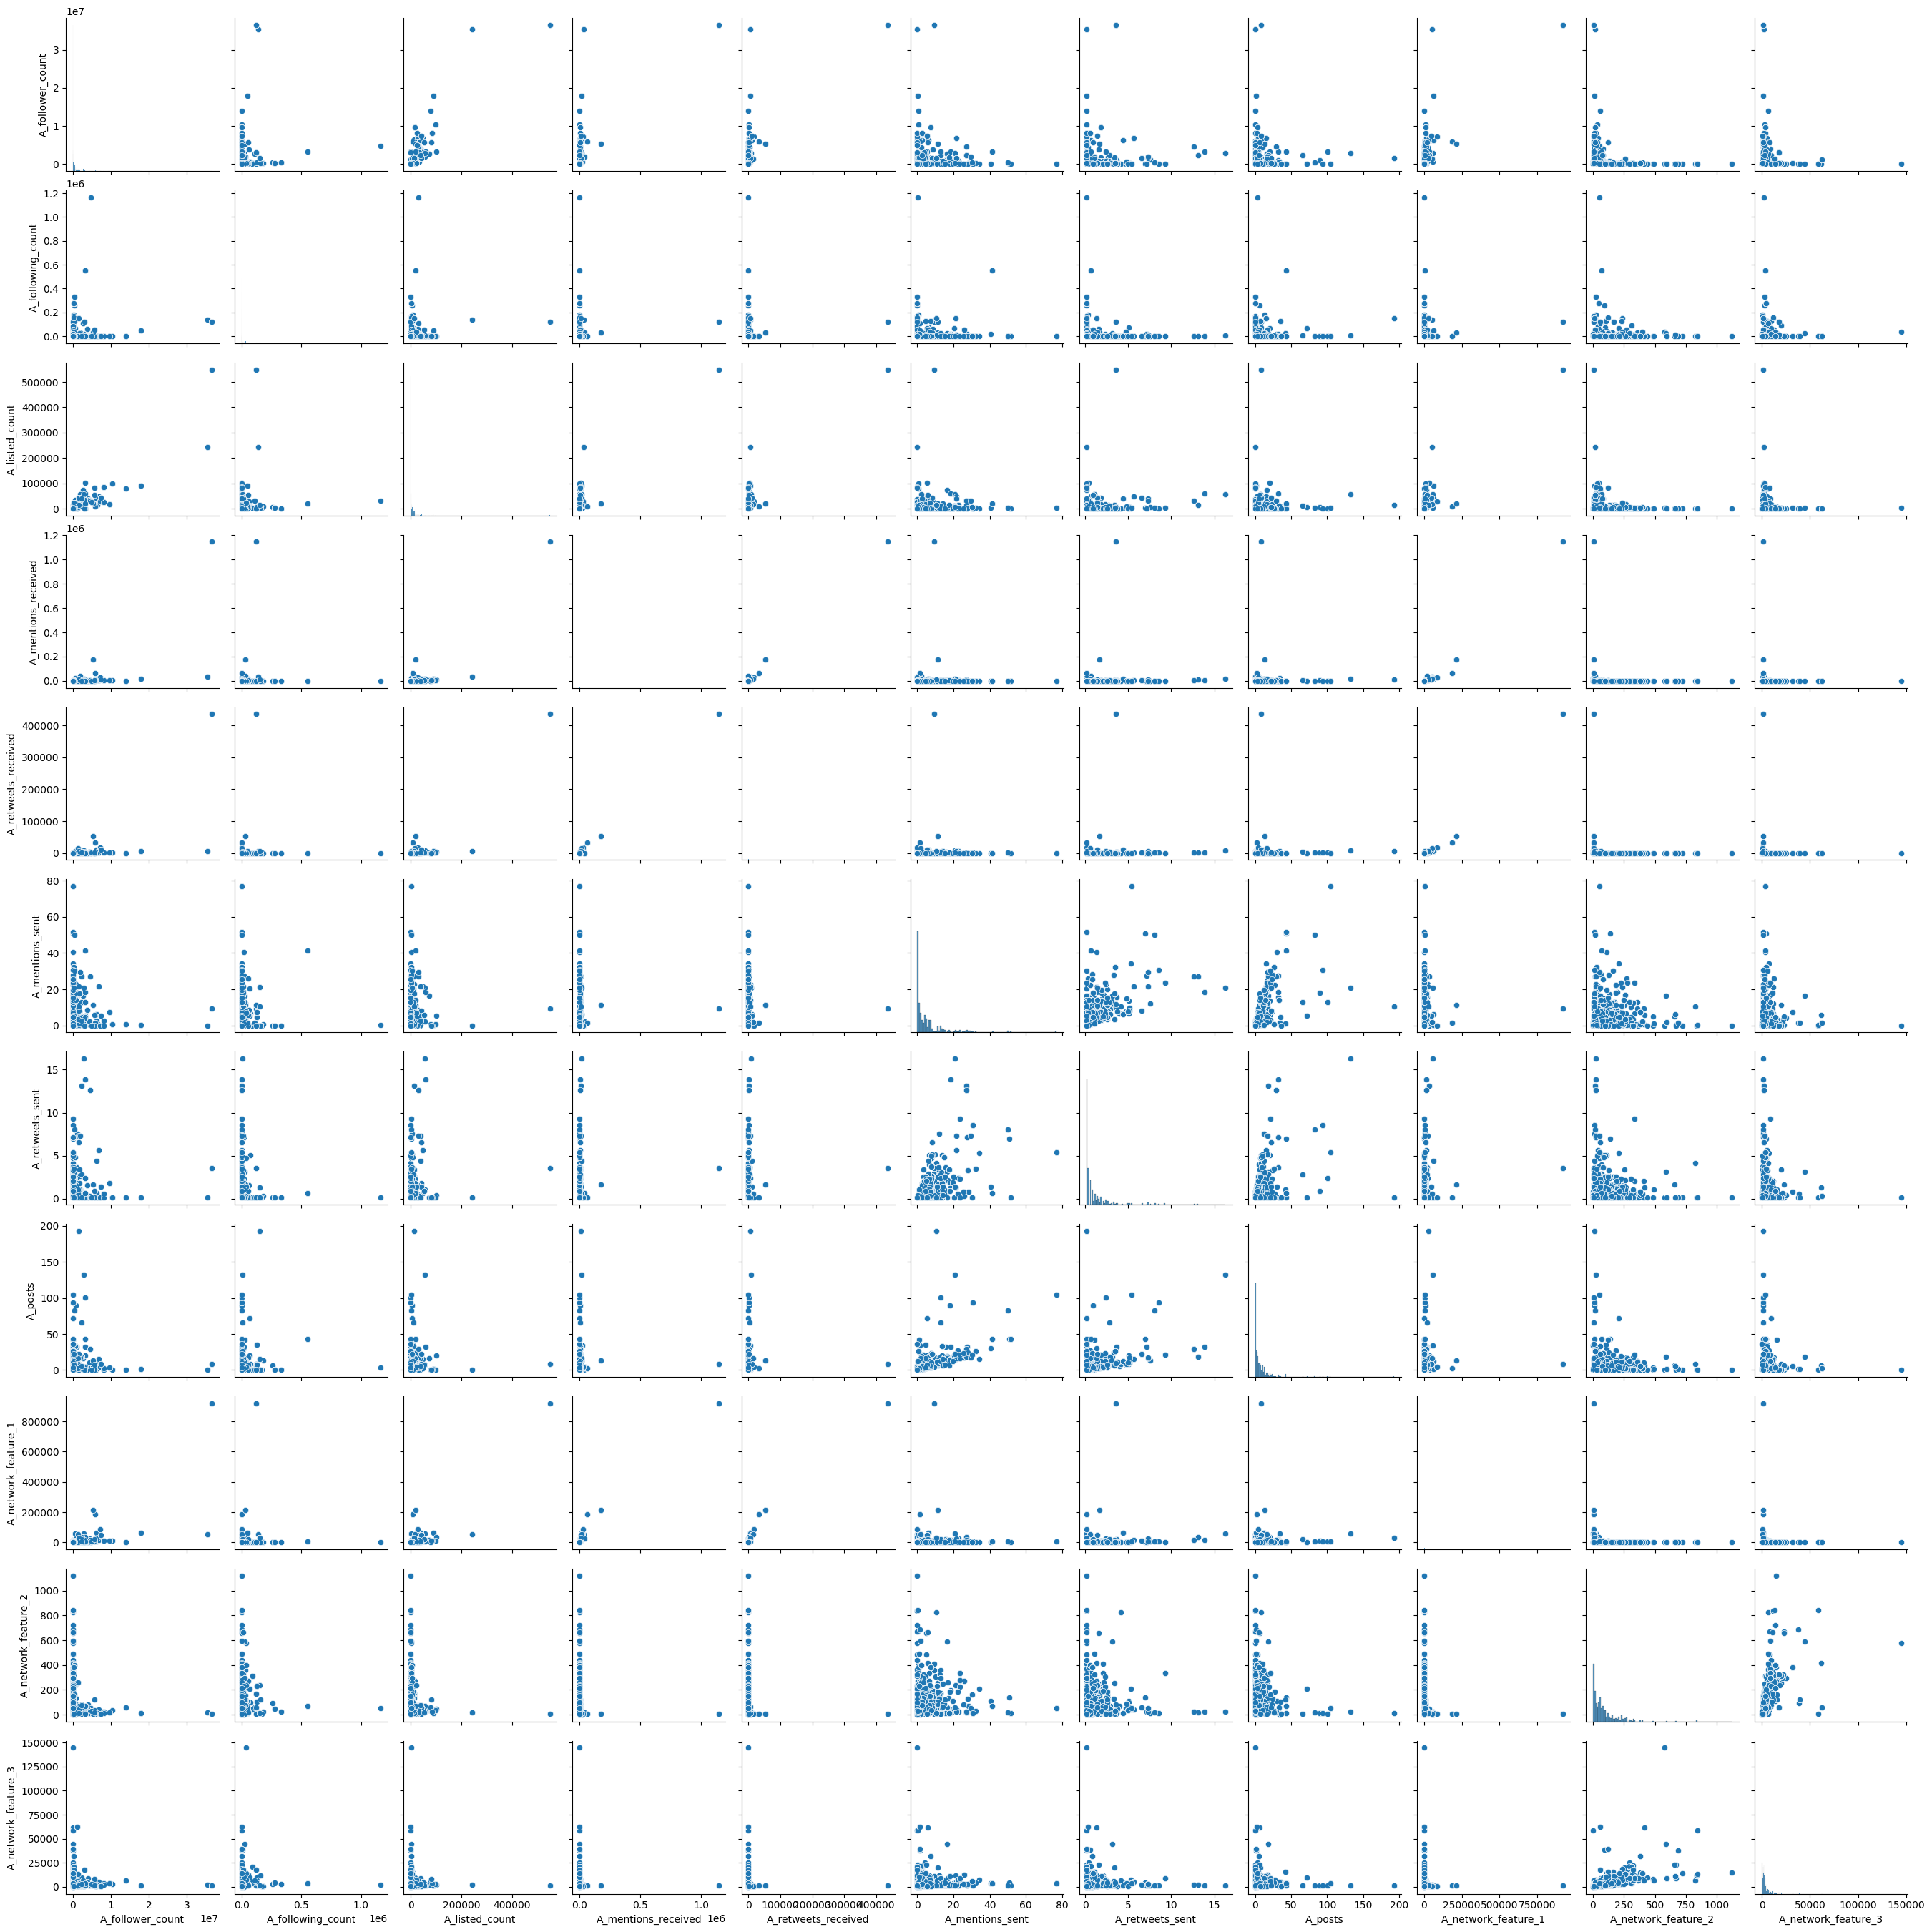

In [9]:
#-- Get a sense of them visually

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming A_cols is a list of columns from data that you want to visualize
A_cols = ['A_follower_count', 'A_following_count', 'A_listed_count', 'A_mentions_received', 'A_retweets_received', 'A_mentions_sent', 'A_retweets_sent', 'A_posts', 'A_network_feature_1', 'A_network_feature_2', 'A_network_feature_3']

# Create a dataframe with only the columns of interest
A_df = data[A_cols]

# Create a pairplot with hue indicating the two possible outcomes - influencers or not
sns.pairplot(A_df)

# Show the plot
plt.show()

In [14]:
sns.pairplot(data=A_df, hue='Choice')
plt.show()

KeyError: 'Choice'

Error in callback <function flush_figures at 0x7b34f481c160> (for post_execute):


KeyboardInterrupt: 

Text(0.5, 80.5815972222222, 'Variables correlations')

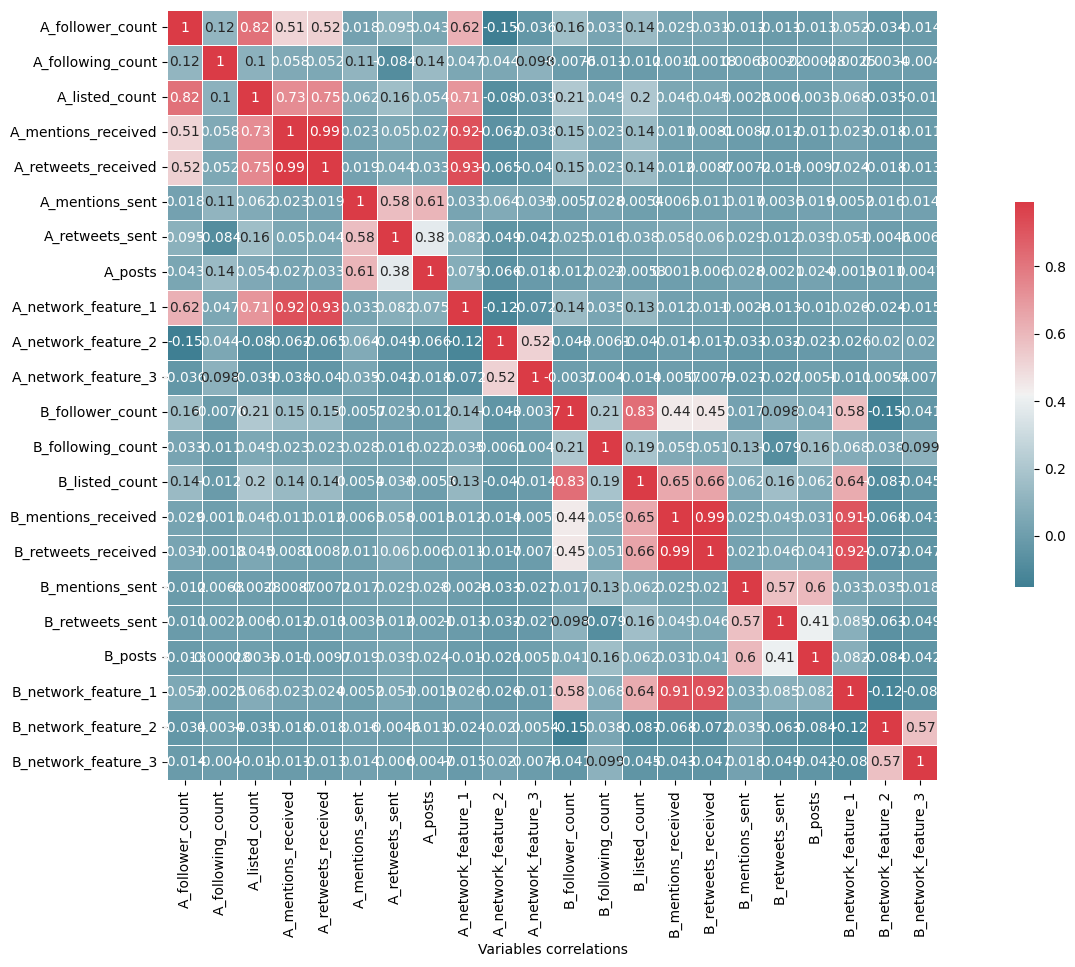

In [15]:
#-- Produce a correlation matrix for the features in A_cols

corr = X.corr(numeric_only = True)

#--Set up the matplotlib figure
fig, ax= plt.subplots(figsize=(20, 10))

#--Generate diverging colormap
cmap= sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap, vmax=.99, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True)
plt.xlabel('Variables correlations')

### Creating new features
Each of the twitter users in a pairing have 11 characteristics each. Some are a bit ambigouous (the data providers have not indicated what "network_feature_1" is for example, but there's not much we can do there). Nonetheless most are self explanatory.

In [16]:
import numpy as np

A_cols = X.columns[:11]
B_cols = X.columns[11:]


In [17]:
A_cols

Index(['A_follower_count', 'A_following_count', 'A_listed_count',
       'A_mentions_received', 'A_retweets_received', 'A_mentions_sent',
       'A_retweets_sent', 'A_posts', 'A_network_feature_1',
       'A_network_feature_2', 'A_network_feature_3'],
      dtype='object')

In [18]:
B_cols

Index(['B_follower_count', 'B_following_count', 'B_listed_count',
       'B_mentions_received', 'B_retweets_received', 'B_mentions_sent',
       'B_retweets_sent', 'B_posts', 'B_network_feature_1',
       'B_network_feature_2', 'B_network_feature_3'],
      dtype='object')

By looking at the correlation matrix, what relationships stand out? Even though we don't know what network_feature_1 and network_feature_2 mean, we can see that they are closely and positively correlated with the number of mentions and retweets received by each user.

A problem remains - we need our model to understand the difference between two users, not just stick their individual features into a model. Let's address this now via some feature engineering:

<span style="font-weight:bold; color:green;">&rarr; Fix this issue by generating new features, that represent the difference between the users for each Twitter statistic (and also the logged version of each):<span/>

In [19]:
X_diff = pandas.DataFrame()

for (a, b) in zip(A_cols, B_cols):
    field_name = "diff_" + a[2:]
    X_diff[field_name] = X[a] - X[b]
    X_diff[field_name + "_logged"] = np.log(X[a]) - np.log(X[b])

X_diff.head()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,diff_follower_count,diff_follower_count_logged,diff_following_count,diff_following_count_logged,diff_listed_count,diff_listed_count_logged,diff_mentions_received,diff_mentions_received_logged,diff_retweets_received,diff_retweets_received_logged,...,diff_retweets_sent,diff_retweets_sent_logged,diff_posts,diff_posts_logged,diff_network_feature_1,diff_network_feature_1_logged,diff_network_feature_2,diff_network_feature_2_logged,diff_network_feature_3,diff_network_feature_3_logged
0,-34235,-5.018296,-29506,-4.592105,-1686,-6.333280,-14.846518,-3.274236,-3.883525,-3.679858,...,-0.231920,-1.196217,-6.626665,-2.960008,-64,-3.496508,90.969697,0.790461,9438.106061,1.778952
1,-17671,-0.597981,331,0.329541,-1382,-1.954644,49.961485,0.803690,16.854685,1.059369,...,0.546816,0.677497,4.106299,1.576194,206,0.817046,-113.587704,-1.968351,-1601.149290,-0.790065
2,3688,0.702217,733,0.924555,-105,-0.712756,24.768949,3.547120,9.201969,3.294594,...,0.490702,1.771973,2.986516,1.783576,92,3.455265,58.594502,1.897685,5722.563574,3.074277
3,-19542,-6.885612,-17630,-7.831844,-276,-4.934474,-565.184032,-4.310639,-390.016375,-7.249534,...,-7.067053,-4.267129,-29.271279,-2.428417,-1756,-5.682445,-21.469296,-2.462546,-1299.678967,-2.675173
4,38035,1.797589,-849,-0.685578,2460,2.680416,127.252413,1.930188,33.417223,2.335061,...,2.213765,1.090936,19.298035,1.654223,466,1.869084,78.904293,0.965802,840.220036,0.351679


### Creating a model of good "micro-influencers"
Ok, now we have better features. Next step is to generate a model that we can use in the future to see if a new influencer is preferred to any of our current influencer targets. To do that, let's feed in our new feature set into a predictive model.

Of course, this is now easy for us - we just use the same tools as we have in the past via sklearn. In this instance let's try a simple fit of Logistic Regression model (if we were doing this for real, obviously we'd try a lot more options, cross validate, and do grid searchers).

<span style="font-weight:bold; color:green;">&rarr; generate an influencer model using Logistic Regression, and see how well it fits via classification accuracy of the training set:<span/>


In [ ]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score

#-- create a logistic regression model (ignore the warniing)
model = linear_model.LogisticRegression(...)
model.fit(...)
lr_pred = model.predict_proba(...)
print(lr_pred)

In [ ]:
#-- convert the probabilities for each class into an actual prediction
lr_pred = [a < 0.5 for a, b in lr_pred]

#-- display the results to check that we have a good model
print("Model has an accuracy of {0:.2f}".format(accuracy_score(...)))

### Finding the key Twitter features which make a good "micro-influencers"
We now have a model. But for the business, perhaps the insight into what makes a good micro-influencer is even more important (explanation rather than prediction!). To do this, let's take the relatively coarse, but quick and simple option of using SelectKBest as we have before.

<span style="font-weight:bold; color:green;">&rarr; Generate a list of the 6 most important features in our influencer model:<span/>

In [ ]:
from sklearn.feature_selection import SelectKBest

selector = SelectKBest()
selector.fit(X_diff, Y)

#-- create a list of pairs, with the importance score zipped up to the feature name
scores = list(zip(selector.scores_, X_diff.columns))

#-- sort those pairs into order of the most important first, and keep the top 6
scores = sorted(scores, key = lambda x: x[0], reverse = True)[:6]

for x,y in scores:
    print("{0:<10.2f} {1}".format(x, y))

You now have the key features which make a good "micro-influencer".

<span style="font-weight:bold; color:green;">&rarr;
 How would you interpret them?